In [11]:
import numpy as np
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization_sg import *

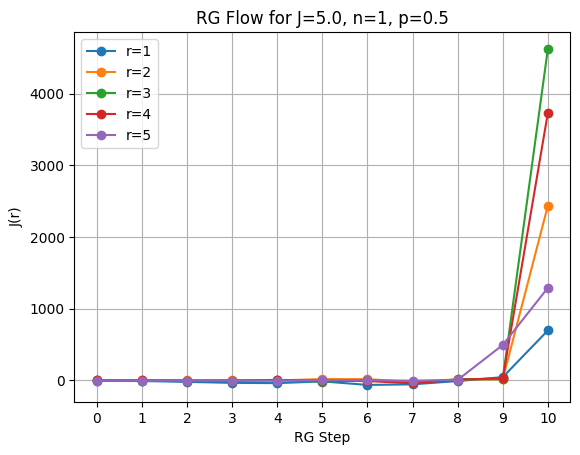

CPU times: user 29min 42s, sys: 3.87 s, total: 29min 46s
Wall time: 29min 53s


In [52]:
%%time
# RG flow

J = 1/0.2
n = 1
p = 0.5
max_k = 100000
num_r_to_plot = 5

all_Js = generate_rg_flow(J0=J, n=n, p=p, max_k=max_k, num_steps=10, seed=42)

# Plot J vs RG step for first num_r_to_plot r
fig = plt.figure()
steps = range(len(all_Js))
for r_idx in range(min(num_r_to_plot, max_k)):
    Js_step = [all_Js[s][r_idx] for s in steps]
    plt.plot(steps, [float(j) for j in Js_step], label=f'r={r_idx+1}', marker='o')
plt.xlabel('RG Step')
plt.ylabel('J(r)')
plt.title(f'RG Flow for J={J}, n={n}, p={p}')
plt.xticks(steps)
plt.legend()
plt.grid(True)
plt.show()

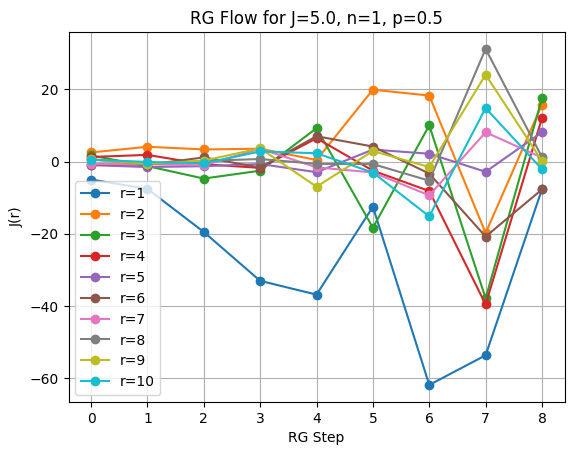

In [53]:
# Plot J vs RG step for first num_r_to_plot r
fig = plt.figure()
steps = range(9)

for r_idx in range(0, 10):
    Js_step = [all_Js[s][r_idx] for s in steps]
    plt.plot(steps, [float(j) for j in Js_step], label=f'r={r_idx+1}', marker='o')
plt.xlabel('RG Step')
plt.ylabel('J(r)')
plt.title(f'RG Flow for J={J}, n={n}, p={p}')
plt.xticks(steps)
plt.legend()
plt.grid(True)
#plt.savefig(f'J{J}n{n}p{p}.png')
plt.show()

For n=1, p=0.0: Tc=3.6624082790691226
For n=1, p=0.034482758620689655: Tc=3.4017223108958357
For n=1, p=0.06896551724137931: Tc=3.351592512210967
For n=1, p=0.10344827586206896: Tc=2.8587213532958295
For n=1, p=0.13793103448275862: Tc=2.5617041808301773
For n=1, p=0.1724137931034483: Tc=2.134404950697513
For n=1, p=0.20689655172413793: Tc=2.3746436212212414
For n=1, p=0.24137931034482757: Tc=2.967230249865449
For n=1, p=0.27586206896551724: Tc=1.8424005208441605
For n=1, p=0.3103448275862069: Tc=99.99627522097552
For n=1, p=0.3448275862068966: Tc=1.887687934124147
For n=1, p=0.3793103448275862: Tc=1.576305161202348
For n=1, p=0.41379310344827586: Tc=2.075274283563536
For n=1, p=0.4482758620689655: Tc=1.330919353738651
For n=1, p=0.48275862068965514: Tc=0.5670334896167744
For n=1, p=0.5172413793103449: Disorder phase, no Tc found
For n=1, p=0.5517241379310345: Disorder phase, no Tc found
For n=1, p=0.5862068965517241: Disorder phase, no Tc found
For n=1, p=0.6206896551724138: Disorder p

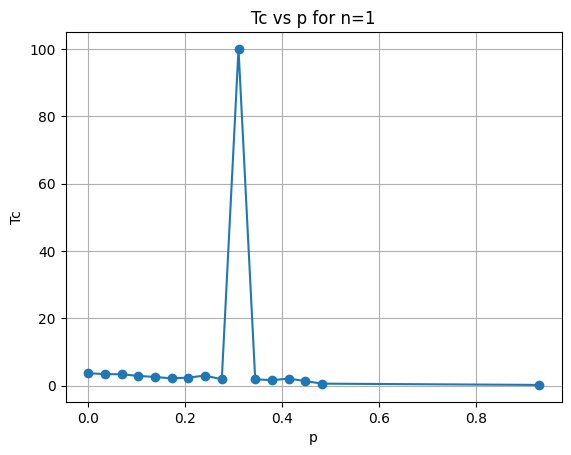

In [27]:
p_values = np.linspace(0, 1, 30, True)
plot_Tc_vs_p(p_values, n=1, max_k=5000, tol=1e-6, seed=42)

## Phase separation lines

## Horizontal line

In [12]:
def find_Tc_fixed_p(n, p, max_k=1000, tol=1e-6, J_low=0.1, J_high=100.0, seed=42, max_steps=7):
    """
    For fixed p, search for Tc (1/Jc) assuming disorder at high T (low J) and ordered at low T (high J).
    """
    if n <= 0 or n >= 2:
        raise ValueError("n must be between 0 and 2, excluding the edges.")
    if p < 0 or p > 1:
        raise ValueError("p must be between 0 and 1.")

    min_max_k = 4
    if max_k < min_max_k:
        raise ValueError(f"max_k should be at least {min_max_k}")

    tol = mp.mpf(tol)
    J_low = mp.mpf(J_low)  # High T
    J_high = mp.mpf(J_high)  # Low T

    def compute_phase(J0):
        all_Js = generate_rg_flow(J0, n, p, max_k, num_steps=max_steps, seed=seed)
        phase = phase_sink(all_Js)
        if phase == 'undecided':
            raise ValueError("Phase undecided; increase max_steps.")
        return phase == 'disorder'  # True if disorder, False if ordered (ferro)

    # Check assumption: disorder at high T (low J)
    phase_low = compute_phase(J_low)
    if not phase_low:
        return None  # Assumption violated: not disorder at high T

    # Check ordered at low T (high J)
    phase_high = compute_phase(J_high)
    if phase_high:
        return None  # Disorder at low T, no transition

    # Bisection: find where phase changes from disorder (high T) to ordered (low T)
    iter_count = 0
    while J_high - J_low > tol and iter_count < 100:
        iter_count += 1
        J_mid = (J_low + J_high) / 2
        phase_mid = compute_phase(J_mid)
        if phase_mid:
            J_low = J_mid  # Disorder: move to higher J (lower T)
        else:
            J_high = J_mid  # Ordered: move to lower J (higher T)
    Jc = (J_low + J_high) / 2
    return 1 / float(Jc)  # Tc = 1 / Jc

In [13]:
np.linspace(0.4, 0.8, 7)

array([0.4       , 0.46666667, 0.53333333, 0.6       , 0.66666667,
       0.73333333, 0.8       ])

In [14]:
n = 1
p_values = np.linspace(0.4, 0.8, 7)
max_k = 22000
tol = 1e-4
seed = 42

# Compute Tc for each p
filtered_p = []
Tc_values = []
for curr_p in p_values:
    Tc = find_Tc_fixed_p(n, curr_p, max_k=max_k, tol=tol,
                         J_low=0.1, J_high=100.0, seed=seed,
                         max_steps=7)
    if Tc is None:
        print(f"For n={n}, p={curr_p}: Disorder phase, no Tc found")
    else:
        filtered_p.append(curr_p)
        Tc_values.append(Tc)
        print(f"For n={n}, p={curr_p}: Tc={Tc}")

# Plot results
if filtered_p:
    plt.figure()
    plt.plot(filtered_p, Tc_values, marker='o')
    plt.xlabel('p (Antiferromagnetic bond concentration)')
    plt.ylabel('Tc')
    plt.title(f'Critical Temperature Tc vs p for n={n}')
    plt.grid(True)
    plt.show()
else:
    print("No phase transitions found for any p.")

For n=1, p=0.4: Tc=1.195047948037132
For n=1, p=0.4666666666666667: Tc=0.8826223828008094


ValueError: Phase undecided; increase max_steps.

## Vertical line

In [ ]:
# Define parameters
n = 1  # Fixed power-law exponent
T_values = np.linspace(0.1, 3.4, 5)
max_k = 22000
tol = 1e-4
seed = 42

# Compute pc for each T
filtered_T = []
pc_values = []
for curr_T in T_values:
    pc = find_pc_fixed_T(n, curr_T, max_k=max_k, tol=tol,
                         p_low=0.01, p_high=0.9, seed=seed,
                         max_steps=8)
    if pc is None:
        print(f"For n={n}, T={curr_T}: No critical p found (ferro or disorder assumption violated or undecided)")
    else:
        filtered_T.append(curr_T)
        pc_values.append(pc)
        print(f"For n={n}, T={curr_T}: pc={pc}")

# Plot results
if filtered_T:
    plt.figure()
    plt.plot(filtered_T, pc_values, marker='o')
    plt.xlabel('T')
    plt.ylabel('pc')
    plt.title(f'Critical p (pc) vs T for n={n}')
    plt.grid(True)
    plt.show()
else:
    print("No critical p found for any T.")